In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Reshape, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, LeakyReLU
from PIL import Image
import os
from tqdm.notebook import tqdm
import tensorflow as tf

In [2]:
images = []

for img_filepath in tqdm(os.listdir("/kaggle/input/faces-dataset-small/faces_dataset_small")):
    img = Image.open("/kaggle/input/faces-dataset-small/faces_dataset_small/" + img_filepath)
    img = img.resize((84,84))
    images.append(img)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [3]:
images = np.array(images)
images.shape

(3143, 84, 84, 3)

In [4]:
images.min(), images.max()

(0, 255)

In [5]:
images = images / 255
images = 2 * images.reshape(-1,84,84,3) - 1
images.min(), images.max()

(-1.0, 1.0)

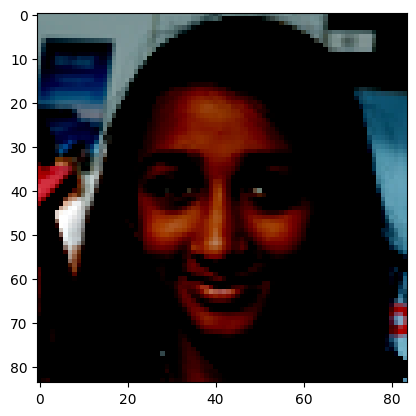

In [6]:
plt.imshow(images[12]);

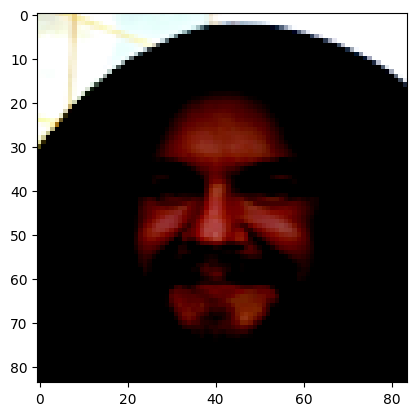

In [7]:
plt.imshow(images[28]);

In [8]:
images.shape

(3143, 84, 84, 3)

In [9]:
batch_size = 64

In [10]:
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(buffer_size=1000)
dataset

<_ShuffleDataset element_spec=TensorSpec(shape=(84, 84, 3), dtype=tf.float64, name=None)>

In [11]:
dataset = dataset.batch(batch_size=batch_size,drop_remainder=True).prefetch(buffer_size=1)
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(64, 84, 84, 3), dtype=tf.float64, name=None)>

In [12]:
images.shape[0]/batch_size

49.109375

In [13]:
tf.random.set_seed(120)
np.random.seed(120)
codings_size = 100

In [14]:
generator = Sequential()
generator.add(Dense(units=21*21*64,activation='relu',input_shape=[codings_size]))
generator.add(Reshape(target_shape=(21,21,64)))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(filters=81,activation='relu',kernel_size=5,strides=2,padding='same'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(filters=3,kernel_size=5,strides=2,padding='same',activation='tanh'))
generator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 28224)          │     2,850,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 42, 42, 81)     │       129,681 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 81)     │           324 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 84, 84, 3)      │         6,078 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,986,963 (11.39 MB)

 Trainable params: 2,986,673 (11.39 MB)

 Non-trainable params: 290 (1.13 KB)

In [15]:
discriminator = Sequential()
discriminator.add(Conv2D(filters=64,kernel_size=5,strides=2,padding='same',activation=LeakyReLU(negative_slope=0.3),input_shape=[84,84,3]))
discriminator.add(Dropout(0.15))
discriminator.add(Conv2D(filters=128,kernel_size=5,strides=2,activation=LeakyReLU(negative_slope=0.3),padding='same'))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(units=1,activation='sigmoid'))
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 42, 42, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        56,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,241 (1.02 MB)

 Trainable params: 266,241 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
GAN = Sequential([generator,discriminator])
GAN.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │     2,986,963 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       266,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,253,204 (12.41 MB)

 Trainable params: 3,252,914 (12.41 MB)

 Non-trainable params: 290 (1.13 KB)

In [17]:
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable = False

In [18]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [19]:
GAN.layers

[<Sequential name=sequential, built=True>,
 <Sequential name=sequential_1, built=True>]

In [20]:
GAN.layers[0].layers

[<Dense name=dense, built=True>,
 <Reshape name=reshape, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Conv2DTranspose name=conv2d_transpose, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Conv2DTranspose name=conv2d_transpose_1, built=True>]

In [21]:
GAN.layers[1].layers

[<Conv2D name=conv2d, built=True>,
 <Dropout name=dropout, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense_1, built=True>]

In [22]:
GAN.layers[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 28224)          │     2,850,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 42, 42, 81)     │       129,681 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 81)     │           324 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 84, 84, 3)      │         6,078 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,986,963 (11.39 MB)

 Trainable params: 2,986,673 (11.39 MB)

 Non-trainable params: 290 (1.13 KB)

In [23]:
GAN.layers[1].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 42, 42, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        56,449 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,241 (1.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 266,241 (1.02 MB)

In [24]:
epochs = 25
generator, discriminator = GAN.layers

for i in range(epochs):
    print(f"Currently on epoch {i+1}")
    cnt = 0
    
    for batch in dataset:
        cnt += 1

        if cnt % 10 == 0:
            print(f"Currently on batch number {cnt} of {len(images)//batch_size}")
            
        # Discriminator Training Phase
        noise = tf.random.normal(shape=[batch_size,codings_size])
        generated_images = generator(noise)
        X_fake_or_real = tf.concat([generated_images,tf.dtypes.cast(batch,tf.float32)],axis=0)
        y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
        discriminator.trainable = True
        discriminator.train_on_batch(X_fake_or_real,y1)
        
        # Generator Training Phase
        noise = tf.random.normal(shape=[batch_size,codings_size])
        discriminator.trainable = False
        y2 = tf.constant([[1.0]]*batch_size)
        GAN.train_on_batch(noise,y2)

Currently on epoch 1


I0000 00:00:1729903486.881934     100 service.cc:145] XLA service 0x7ba3480041b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729903486.881989     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729903490.776030     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 2
Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 3
Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 4
Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 5
Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 6
Currently on batch number 10 of 49
Currently on batch number 20 of 49
Currently on batch number 30 of 49
Currently on batch number 40 of 49
Currently on epoch 7
Currently on batch number 10 of 49

In [27]:
noise = tf.random.normal(shape=[25,codings_size])
generated_images = generator(noise)
generated_images.shape

TensorShape([25, 84, 84, 3])

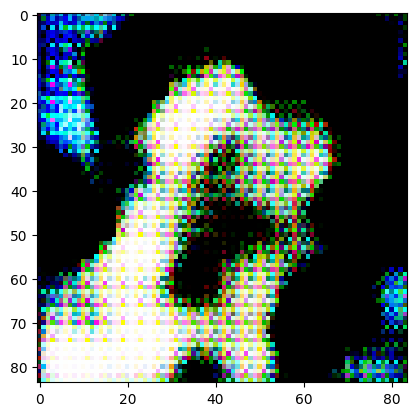

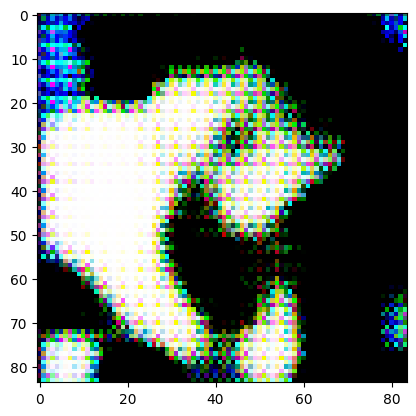

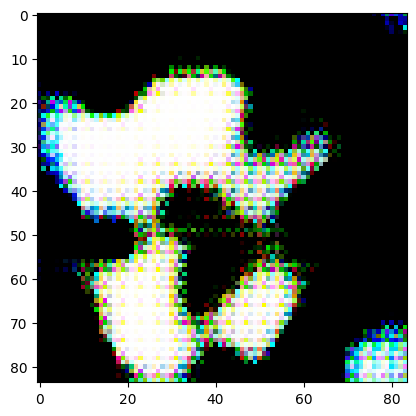

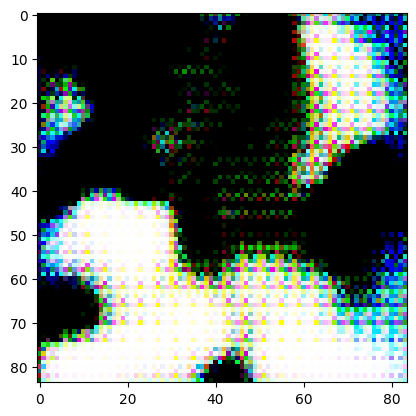

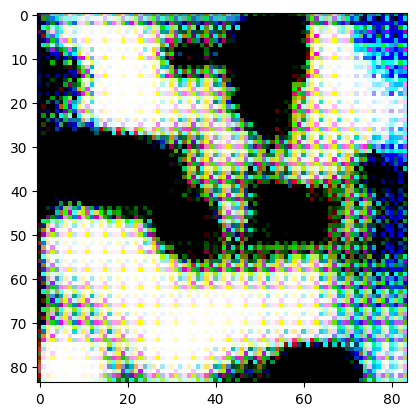

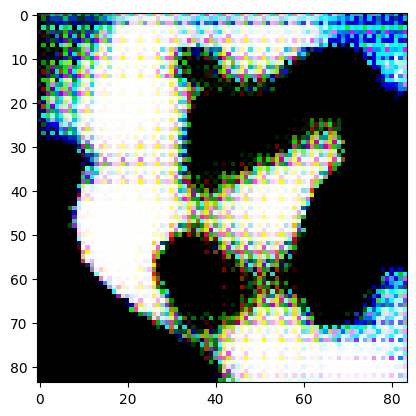

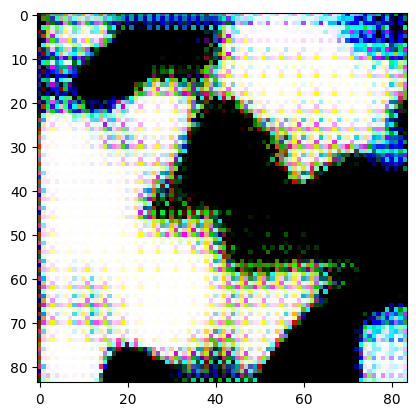

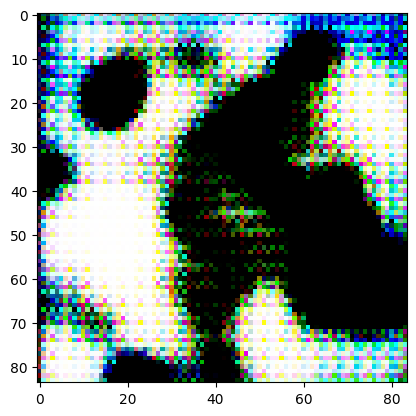

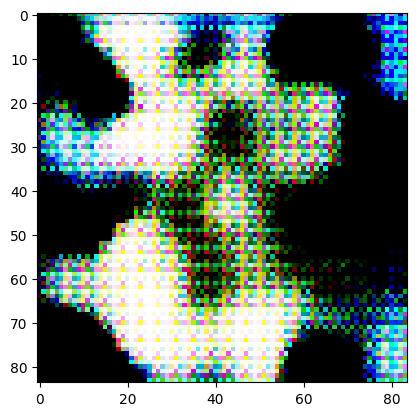

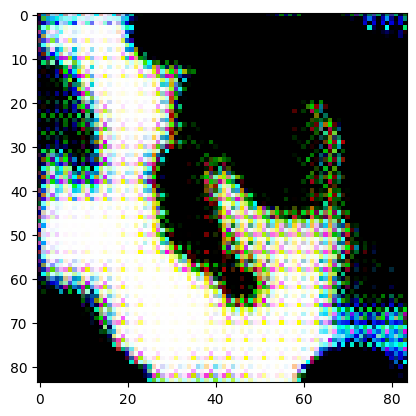

In [29]:
for i in range(10):
    plt.imshow(generated_images[i])
    plt.show()